In [12]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.util import invert, crop
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu, threshold_yen, gaussian, median
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin

from scipy.spatial.distance import euclidean

import os
import cv2


In [13]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 


In [14]:
# find the angle between the three points A,B,C
# Angle between line BA and BC
def angle_between_three_points(pointA, pointB, pointC):
    BA = pointA - pointB
    BC = pointC - pointB
    try:
        cosine_angle = np.dot(BA, BC) / (np.linalg.norm(BA) * np.linalg.norm(BC))
        angle = np.arccos(cosine_angle)
    except:
        print("exc")
        raise Exception('invalid cosine')
    return np.degrees(angle)

In [15]:
def point_in_cluster(point, cluster):
    for x in cluster:
        if x[0] == point[0] and x[1] == point[1]:
            return True
    return False

<ipython-input-16-a17f4ce23830>:3: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  gray_img = rgb2gray(car)


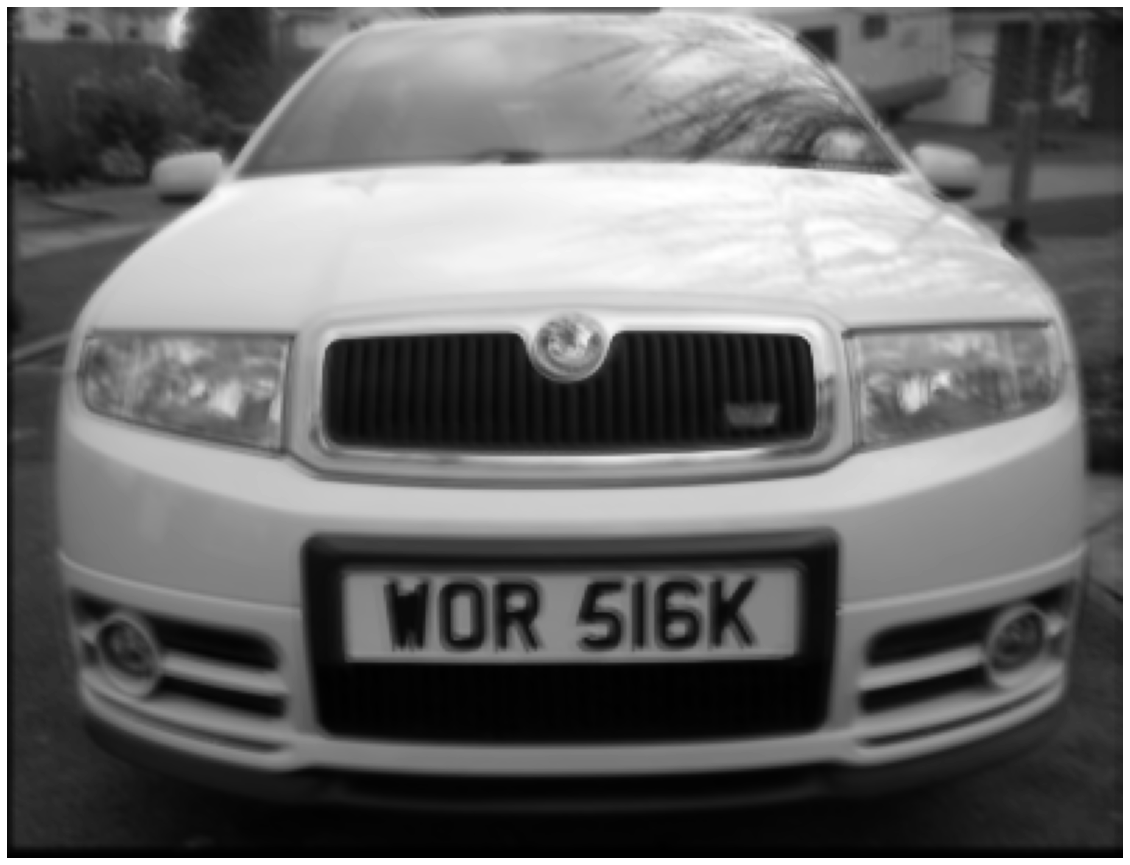

In [16]:
# read the image and convert it to grayscale
car = imread('./images/22.png')
gray_img = rgb2gray(car)

#blur the image to remove any noise
# blurred_gray_img = median(gray_img)
# blurred_gray_img = gaussian(gray_img)
blurred_gray_img = denoise_bilateral(gray_img)

plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(blurred_gray_img, cmap="gray")

## Binarize the image to seperate the foreground from background.

0.4121482852194643


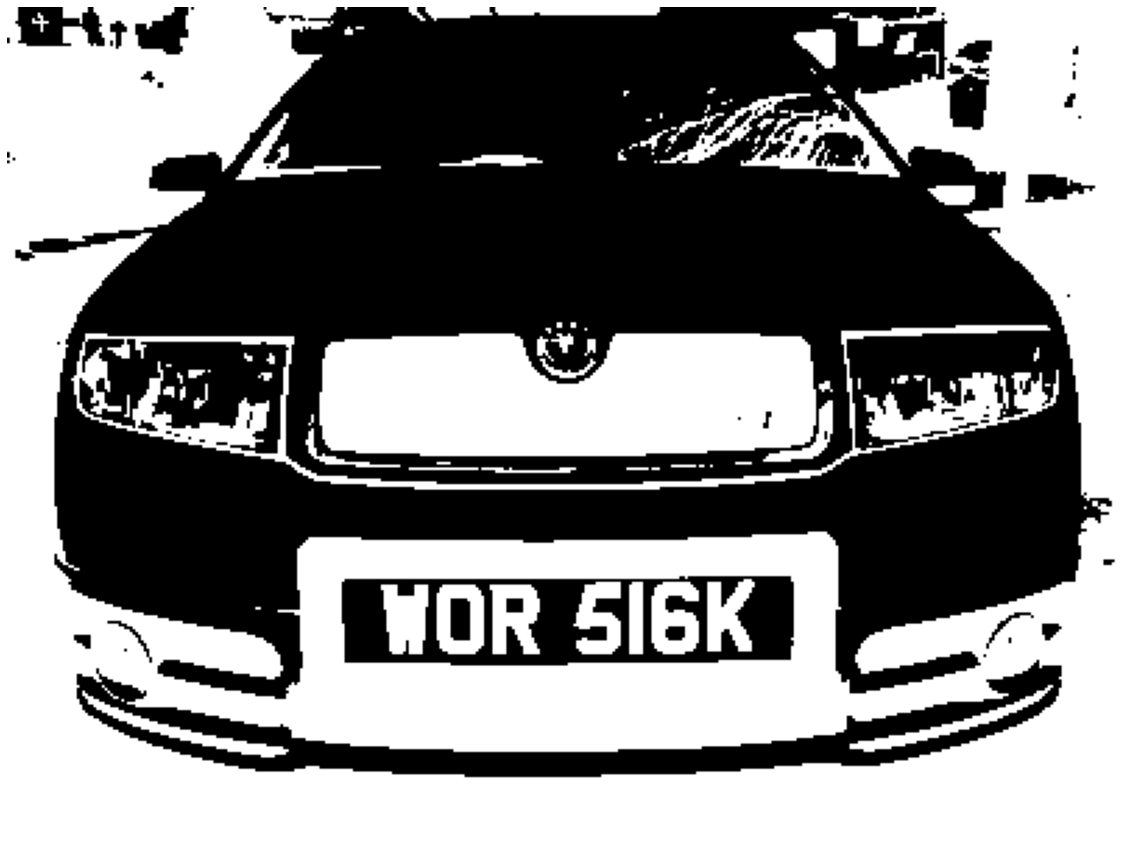

In [17]:
thresh = threshold_otsu(blurred_gray_img)
# thresh = threshold_yen(blurred_gray_img)
print(thresh)
binary = invert(gray_img > thresh)

plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(binary, cmap="gray")

## Connectivity set to 2 for 8 connected regions.

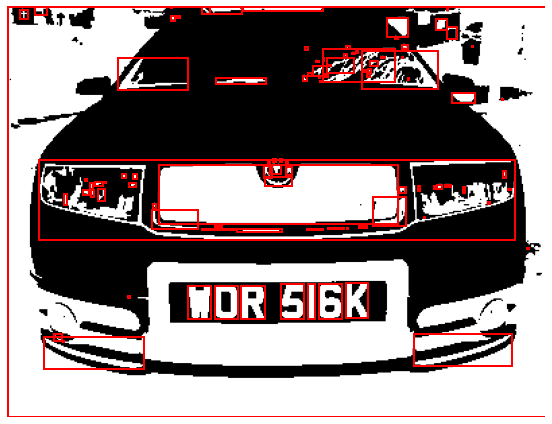

In [18]:
label_image = label(binary, connectivity=2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")
ax.imshow(binary, cmap="gray")

for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

## Identify regions containing text.

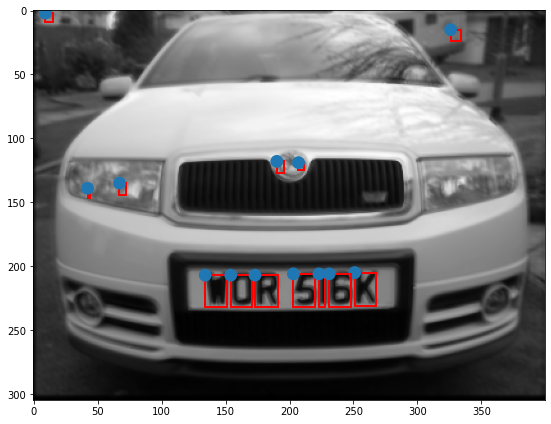

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(blurred_gray_img, cmap="gray")

text_like_regions = []
for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    w = maxc - minc
    h = maxr - minr
    
    asr = w/h
    
    region_area = w*h
    
    wid,hei = blurred_gray_img.shape
    img_area = wid*hei
    
    # The aspect ratio is less than 1 to eliminate highly elongated regions
    # The size of the region should be greater than 15 pixels but smaller than 1/5th of the image
    # dimension to be considered for further processing
    if region_area > 15 and region_area < (0.2 * img_area) and asr < 1 and h > w:
        #print(w, h, i, region.area, region.bbox)
        text_like_regions.append(region)

all_points = []
for region in text_like_regions:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), (maxc - minc), (maxr - minr), fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    circ = mpatches.Circle((minc, minr), radius=5)
    ax.add_patch(circ)
    all_points.append([minc, minr, maxc, maxr])
    
plt.tight_layout()
plt.show()        

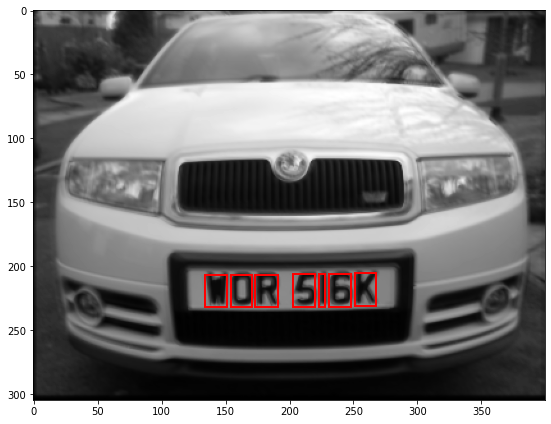

In [25]:
all_points = np.array(all_points)
all_points = all_points[all_points[:,1].argsort()]

height, width = blurred_gray_img.shape
groups = []

LOW_ANGLE = 170
HIGH_ANGLE = 190
HFACTOR = 2
GAP_FACTOR = 1.2

best = []
largest = 0

for i, p in enumerate(all_points):
    cluster = [p]
    lines_found = False
    for j, q in enumerate(all_points):
        pmin = np.array([p[0], p[1]])
        qmin = np.array([q[0], q[1]])
        pheight = abs(p[1] - p[3])
        qheight = abs(q[1] - q[3])
        hdiff = abs(pheight - qheight)
        gap = abs(p[3] - q[1])
        if(j != i and 
           hdiff < HFACTOR and 
           not point_in_cluster(q, cluster)):
            cluster.append(q)
            for k, r in enumerate(all_points):
                l = cluster[-1]
                rmin = np.array([r[0], r[1]])
                rheight = abs(r[1] - r[3])
                hdiff = abs(pheight - rheight)
                cur_gap = abs(l[3] - r[1])
                if(k != i and k != j and 
                   hdiff < HFACTOR and 
                   cur_gap <= gap * GAP_FACTOR and
                   not point_in_cluster(r, cluster)):
                    angle = angle_between_three_points(pmin, qmin, rmin)
                    if (angle > LOW_ANGLE and angle < HIGH_ANGLE):
                        lines_found = True
                        cluster.append(r)                           
    if lines_found:
        groups.append(np.array(cluster))
        total_area = 0
        for box in cluster:
            total_area += abs(box[2] - box[0]) * abs(box[3] - box[1])
        if total_area > largest:
            largest = total_area
            best = cluster
            

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(blurred_gray_img, cmap="gray")

for region in best:
    minc = region[0]
    minr = region[1] 
    maxc = region[2]
    maxr = region[3]
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

best = np.array(best)
best = best[best[:,0].argsort()]

## Extract Letters and Digits

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[]
[]
[([[0, 0], [18, 0], [18, 25], [0, 25]], 'R', 0.9854202354317785)]
[([[0, 1], [17, 1], [17, 26], [0, 26]], '5', 0.999985933353301)]
[]
[([[0, 0], [17, 0], [17, 26], [0, 26]], '6', 0.9543311282871549)]
[]


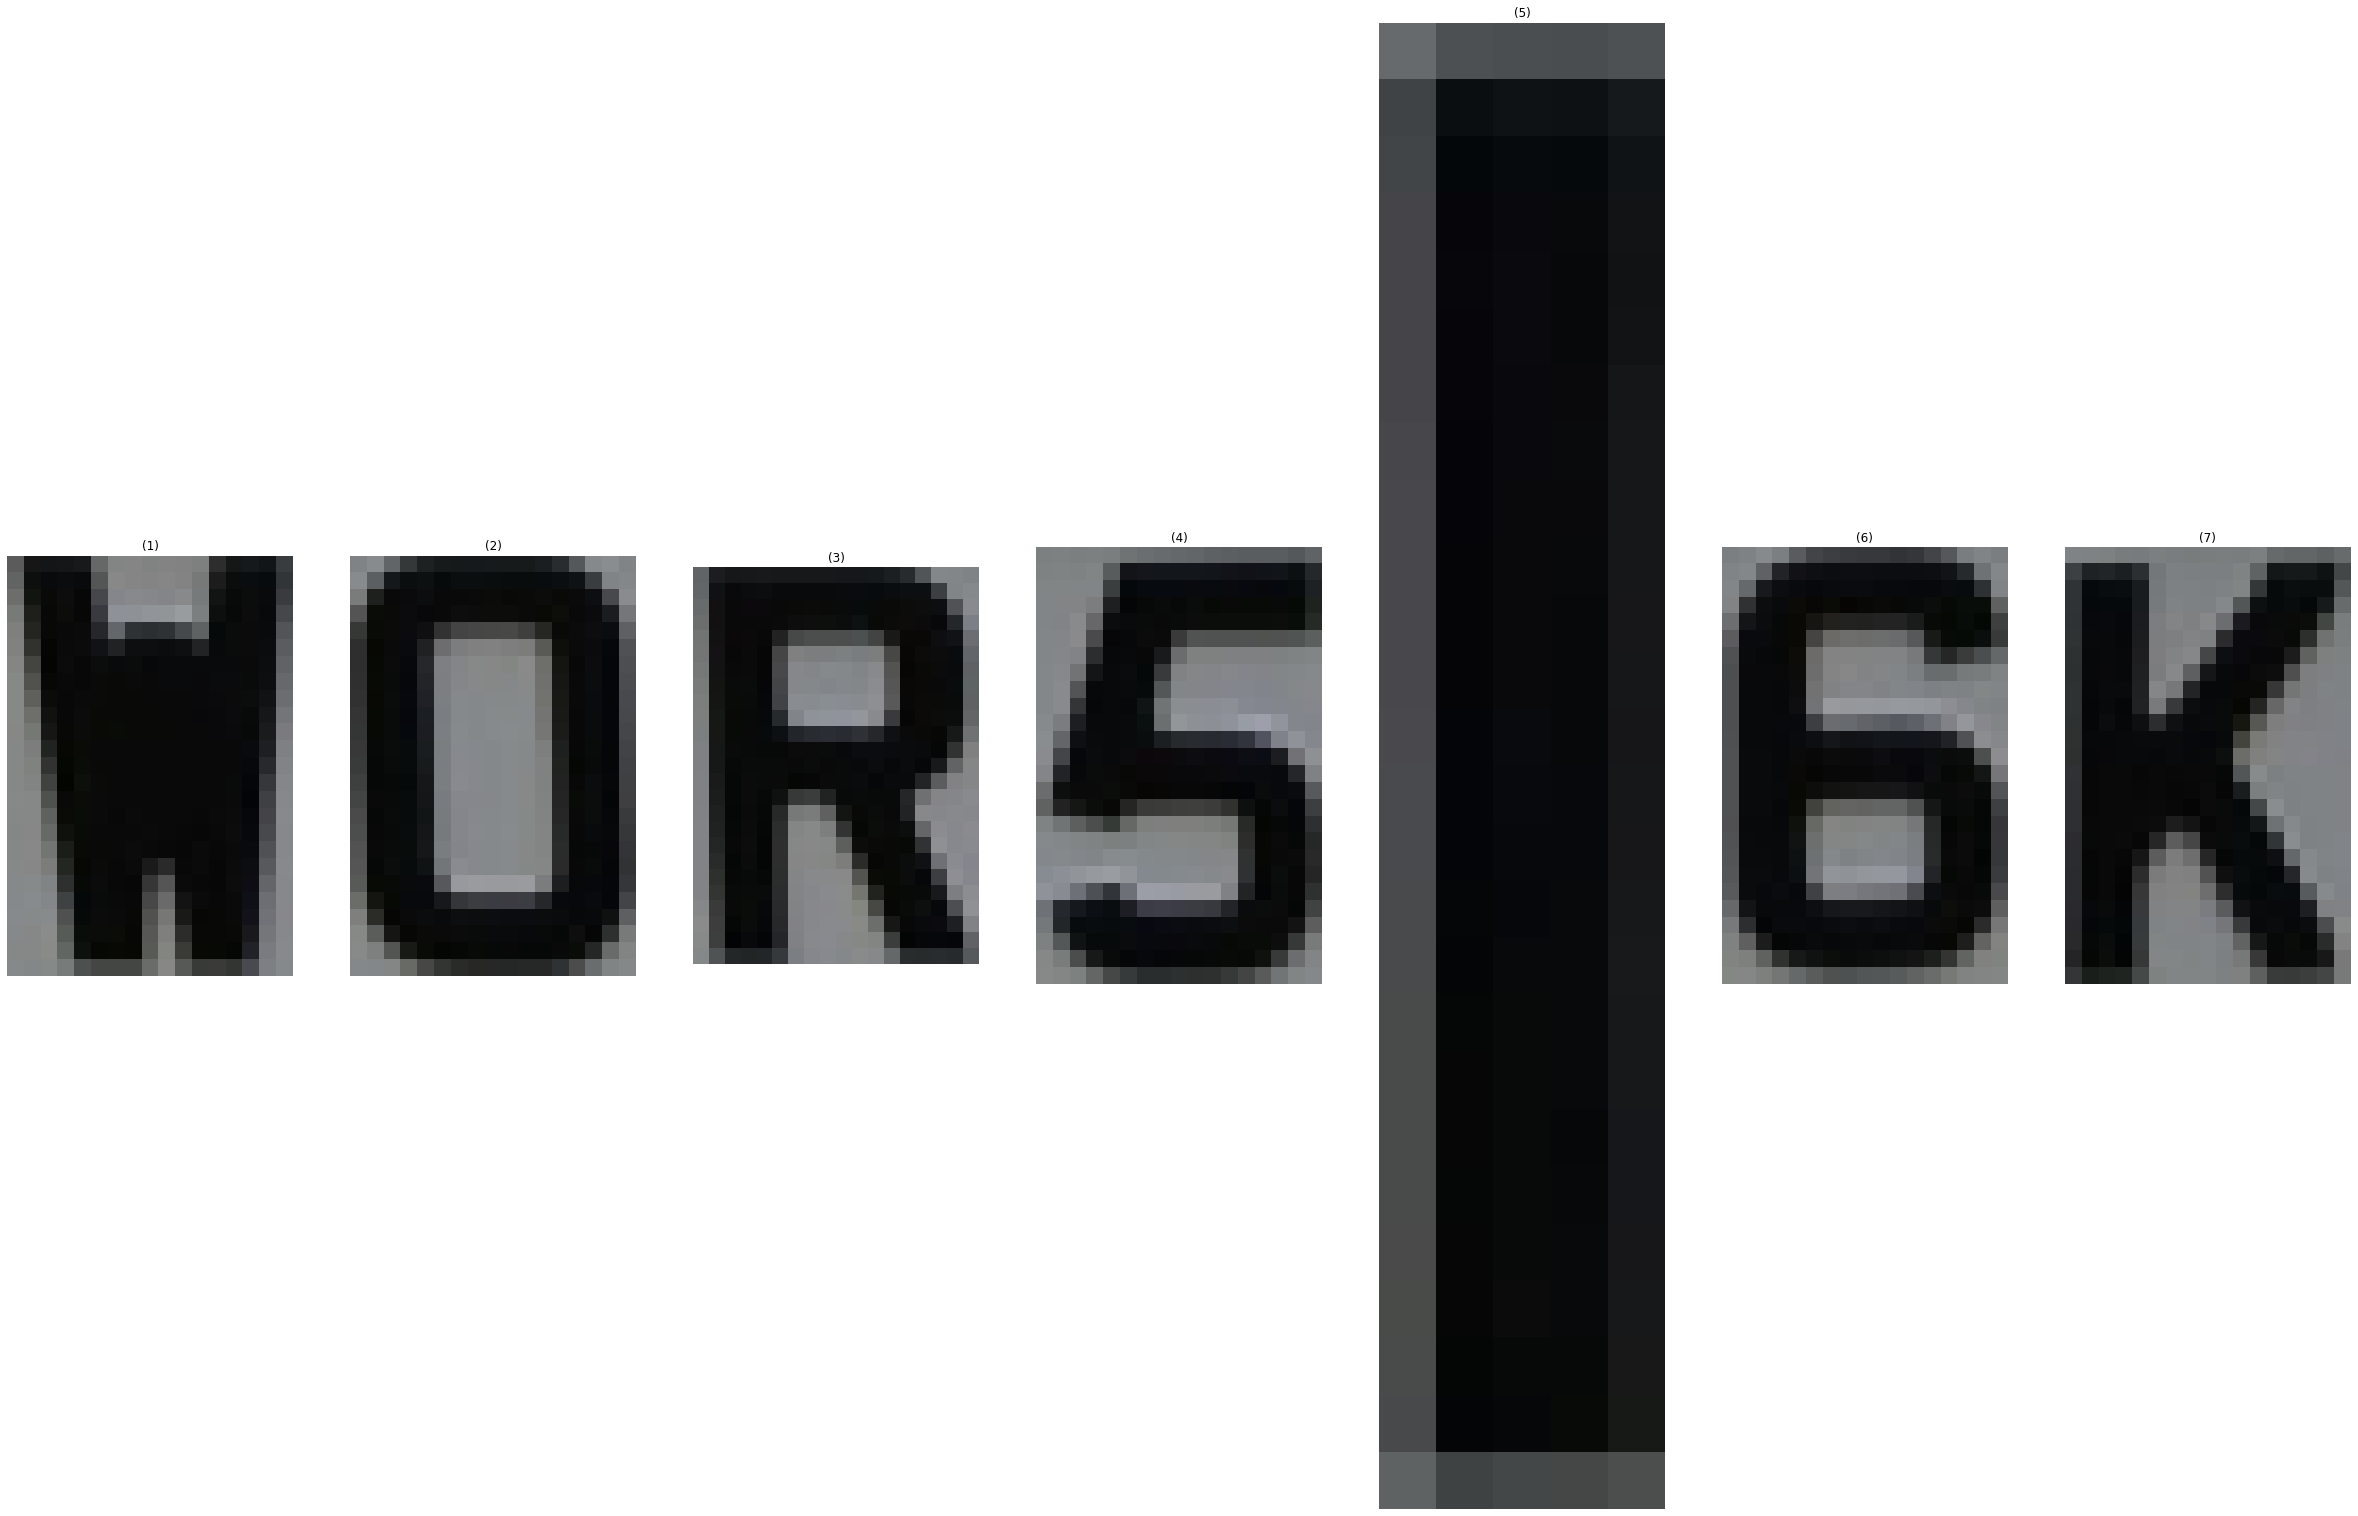

In [26]:
import easyocr

plate_letters = []
reader = easyocr.Reader(['en'])
ADD = 0

for region in best:
    minc = region[0]
    minr = region[1] 
    maxc = region[2]
    maxr = region[3]
    cropped = car[minr-ADD:maxr+ADD, minc-ADD:maxc+ADD]
    plate_letters.append(cropped)
    result = reader.readtext(cropped)
    print(result)

show_images(plate_letters)

## Using EasyOCR

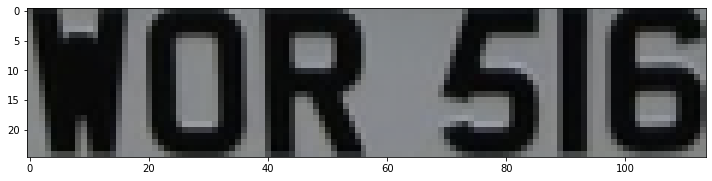

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[[[[0, 0], [114, 0], [114, 25], [0, 25]], 'Qor 516']]

In [27]:
import easyocr
ADD = 0
full_plate = car[best[0][1]-ADD:best[-2][3]+ADD, best[0][0]-ADD:best[-2][2]+ADD]
# thresh = threshold_otsu(full_plate)
# full_plate = invert(full_plate > thresh)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(full_plate, cmap="gray")
plt.tight_layout()
plt.show()

reader = easyocr.Reader(['en'])
result = reader.readtext(full_plate, paragraph="False")
result